# Python with Fantasy Football

Part 3 (https://www.fantasyfootballdatapros.com/blog/intermediate/3)

## Masks and Stacking Players

In this part we are going to show that we can expand on our heat map and maybe give some ideas for some other avenues to take it.

The main difference here is moving around some lines and filtering out running backs with less than 5 catches per game.

In [57]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

pd.options.mode.chained_assignment = None

The line is there to suppress a warning pandas tries to give us about slicing the dataframe.

In [58]:
#Import our CSV file
df = pd.read_csv('2019.csv')
df.head()

,Rk,Player,Tm,FantPos,Age,G,GS,Cmp,Att,Yds,...,TD.3,2PM,2PP,FantPt,PPR,DKPt,FDPt,VBD,PosRank,OvRank
0,1,Christian McCaffrey*\McCaCh01,CAR,RB,23,16,16,0,2,0,...,19,1.0,NaN,355.0,471.2,477.2,413.2,215.0,1,1.0
1,2,Lamar Jackson*\JackLa00,BAL,QB,22,15,15,265,401,3127,...,7,NaN,1.0,418.0,417.7,431.7,423.7,152.0,1,2.0
2,3,Derrick Henry*\HenrDe00,TEN,RB,25,15,15,0,0,0,...,18,NaN,NaN,277.0,294.6,303.6,285.6,136.0,2,3.0
3,4,Aaron Jones\JoneAa00,GNB,RB,25,16,16,0,0,0,...,19,NaN,NaN,266.0,314.8,322.8,290.3,125.0,3,4.0
4,5,Ezekiel Elliott*\ElliEz00,DAL,RB,24,16,16,0,0,0,...,14,NaN,NaN,258.0,311.7,319.7,284.7,117.0,4,5.0


In [59]:
#View Headings
df.columns

Index(['Rk', 'Player', 'Tm', 'FantPos', 'Age', 'G', 'GS', 'Cmp', 'Att', 'Yds',
       'TD', 'Int', 'Att.1', 'Yds.1', 'Y/A', 'TD.1', 'Tgt', 'Rec', 'Yds.2',
       'Y/R', 'TD.2', 'Fmb', 'FL', 'TD.3', '2PM', '2PP', 'FantPt', 'PPR',
       'DKPt', 'FDPt', 'VBD', 'PosRank', 'OvRank'],
      dtype='object')

In [60]:
#Drop Unneccessary columns
df.drop(['Rk', '2PM', '2PP', 'FantPt', 'DKPt', 'FDPt', 
         'VBD', 'PosRank', 'OvRank', 'PPR', 'Fmb', 
         'GS', 'Age', 'Tgt', 'Y/A', 'Att', 'Att.1', 'Cmp', 'Y/R'], axis=1, inplace=True)

#Clean Player Column
df['Player'] = df['Player'].apply(lambda x: x.split('*')[0]).apply(lambda x: x.split('\\')[0])

#Rename Columns
df.rename({
'FantPos' : 'Pos',   
'TD': 'PassingTD',
'TD.1': 'RushingTD',
'TD.2': 'ReceivingTD',
'TD.3': 'TotalTD',
'Yds': 'PassingYDs',
'Yds.1': 'RushingYDs',
'Yds.2': 'ReceivingYDs',
}, axis=1, inplace=True)

#Show Results
df.head()

,Player,Tm,Pos,G,PassingYDs,PassingTD,Int,RushingYDs,RushingTD,Rec,ReceivingYDs,ReceivingTD,FL,TotalTD
0,Christian McCaffrey,CAR,RB,16,0,0,0,1387,15,116,1005,4,0,19
1,Lamar Jackson,BAL,QB,15,3127,36,6,1206,7,0,0,0,2,7
2,Derrick Henry,TEN,RB,15,0,0,0,1540,16,18,206,2,3,18
3,Aaron Jones,GNB,RB,16,0,0,0,1084,16,49,474,3,2,19
4,Ezekiel Elliott,DAL,RB,16,0,0,0,1357,12,54,420,2,2,14


In [61]:
#Create Columns for Fantasy Points
df['FantasyPoints'] = (df['PassingYDs']*0.04 + df['PassingTD']*4 - df['Int']*2 + df['RushingYDs']*0.1 + df['RushingTD']*6 + df['Rec']*1 + df['ReceivingYDs']*0.1 + df['ReceivingTD']*6 - df['FL']*2)

df['FantasyPoints/G'] = df['FantasyPoints']/df['G']

#Remove Players on Two or More Teams
df = df[df['Tm'] != '2TM']
df = df[df['Tm'] != '3TM']

df.head()

,Player,Tm,Pos,G,PassingYDs,PassingTD,Int,RushingYDs,RushingTD,Rec,ReceivingYDs,ReceivingTD,FL,TotalTD,FantasyPoints,FantasyPoints/G
0,Christian McCaffrey,CAR,RB,16,0,0,0,1387,15,116,1005,4,0,19,469.20,29.32500
1,Lamar Jackson,BAL,QB,15,3127,36,6,1206,7,0,0,0,2,7,415.68,27.71200
2,Derrick Henry,TEN,RB,15,0,0,0,1540,16,18,206,2,3,18,294.60,19.64000
3,Aaron Jones,GNB,RB,16,0,0,0,1084,16,49,474,3,2,19,314.80,19.67500
4,Ezekiel Elliott,DAL,RB,16,0,0,0,1357,12,54,420,2,2,14,311.70,19.48125


In [62]:
#Create New Column for Catches/Game
rb_df = df[df['Pos'] == 'RB']
rb_df['Rec/G'] = rb_df['Rec']/rb_df['G']
rb_df = rb_df[rb_df['Rec/G'] > 5]

df = df[['Tm', 'Pos', 'FantasyPoints', 'FantasyPoints/G']]
rb_df = df[['Tm', 'Pos', 'FantasyPoints', 'FantasyPoints/G']]

rb_df = rb_df[rb_df['Tm'] != '2TM']
rb_df = rb_df[rb_df['Tm'] != '3TM']

#Separate Dataframes by Position
qb_df = df[df['Pos'] == 'QB']
wr_df = df[df['Pos'] == 'WR']
te_df = df[df['Pos'] == 'TE']

rb_df.head()

,Tm,Pos,FantasyPoints,FantasyPoints/G
0,CAR,RB,469.20,29.32500
1,BAL,QB,415.68,27.71200
2,TEN,RB,294.60,19.64000
3,GNB,RB,314.80,19.67500
4,DAL,RB,311.70,19.48125


In [63]:
#Create Sample Dataframe
examp_column_names = ['QB1', 'RB1', 'RB2', 'WR1', 'WR2', 'WR3', 'TE']

random_numbers = np.random.randn(10, 7)

example_df = pd.DataFrame(random_numbers, columns=examp_column_names)

example_df

,QB1,RB1,RB2,WR1,WR2,WR3,TE
0,0.323339,0.166373,0.090736,2.367561,1.172332,-0.990579,0.759531
1,-0.119086,0.073341,-0.279797,0.032222,0.387240,-0.907497,2.626613
2,-0.116417,-0.222636,-0.330430,0.512707,0.440727,-0.179650,0.007141
3,-0.168711,0.305759,-0.290483,1.745977,-2.780756,0.982834,-0.006376
4,1.456114,-0.711063,0.772619,0.092866,-0.333975,-1.556840,0.776864
5,1.506012,-0.689549,0.630882,1.608317,-0.073237,1.678765,0.609232
6,-1.897696,0.817315,0.514821,-0.035374,-2.133767,-2.487400,-0.833058
7,-0.969895,0.535802,-0.038718,-0.594118,0.541622,0.042678,0.059063
8,-2.629634,1.071125,0.044959,0.528649,-0.129640,0.933989,-0.485968
9,1.216840,-0.522382,-0.118026,-0.683759,-3.267840,0.750040,-0.490311


In [64]:
#Create Correlation Matrix
def get_top_players(df, n):
    return df.groupby('Tm').apply(lambda x: x.nlargest(n, ['FantasyPoints']).min()).reset_index(drop=True)

qb_df = get_top_players(qb_df, 1)
te_df = get_top_players(te_df, 1)
rb1_df = get_top_players(rb_df, 1)
rb2_df = get_top_players(rb_df, 2)
wr1_df = get_top_players(wr_df, 1)
wr2_df = get_top_players(wr_df, 2)
wr3_df = get_top_players(wr_df, 3)

new_names = {
    'QB1': qb_df,
    'TE1': te_df,
    'RB1': rb1_df,
    'RB2': rb2_df,
    'WR1': wr1_df,
    'WR2': wr2_df,
    'WR3': wr3_df
}

for name, new_df in new_names.items():
    new_df.rename({'FantasyPoints/G': name}, axis=1, inplace=True)
    new_df.drop(['Pos', 'FantasyPoints'], axis=1, inplace=True)
    new_df.set_index('Tm', inplace=True)
    
df = pd.concat([qb_df, te_df, rb1_df, rb2_df, wr1_df, wr2_df, wr3_df], axis=1)

df.head()

,QB1,TE1,RB1,RB2,WR1,WR2,WR3
Tm,,,,,,,
ARI,17.455000,3.180000,17.455000,11.087500,11.087500,11.087500,6.536364
ATL,17.689333,14.592308,18.273333,17.689333,18.273333,15.000000,6.175000
BAL,27.712000,13.813333,27.712000,15.900000,10.457143,5.943750,3.756250
BUF,17.660000,5.313333,17.660000,14.654667,14.654667,12.053333,4.220000
CAR,13.652308,8.835714,29.325000,15.366667,15.366667,10.731250,3.556250


In [66]:
#View Correlation Matrix
df.corr()

,QB1,TE1,RB1,RB2,WR1,WR2,WR3
QB1,1.000000,0.324345,0.628504,0.612037,0.229304,0.215667,0.156623
TE1,0.324345,1.000000,0.301213,0.307466,-0.012109,-0.015613,-0.034101
RB1,0.628504,0.301213,1.000000,0.598797,0.341397,0.065314,-0.157144
RB2,0.612037,0.307466,0.598797,1.000000,0.612521,0.362565,0.148811
WR1,0.229304,-0.012109,0.341397,0.612521,1.000000,0.245053,0.029375
WR2,0.215667,-0.015613,0.065314,0.362565,0.245053,1.000000,0.410028
WR3,0.156623,-0.034101,-0.157144,0.148811,0.029375,0.410028,1.000000


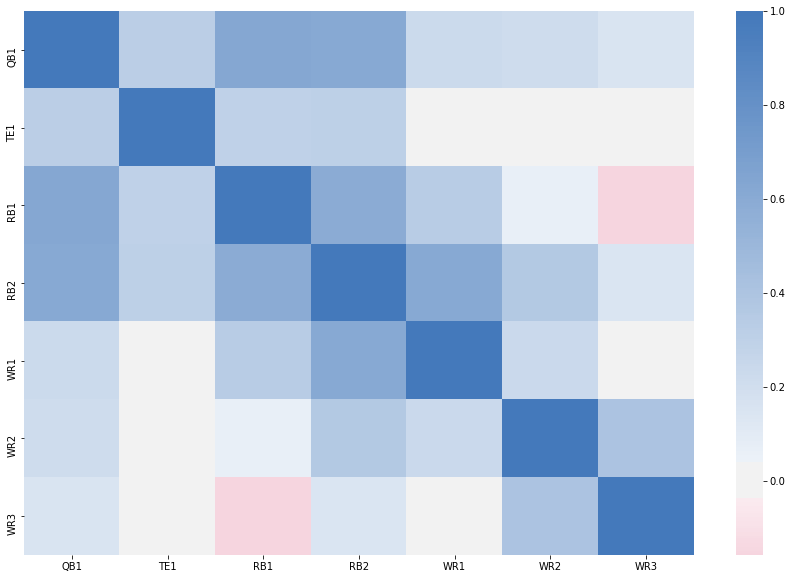

In [67]:
#Create Heatmap
corrMatrix = df.corr()

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

cmap = sns.diverging_palette(0, 250, as_cmap=True)

vizCorrMatrix = sns.heatmap(corrMatrix,cmap=cmap, center=0)

Thoughts: Correlation between QB and RB output is higher after removing RBs with under 5 catches. 

How to improve the heatmap? 

Looking at our heat map, we notice that it’s completely symmetrical and that we only really need to include half of it. we also notice that when the same position matches up with itself, for example, at QB-QB, the correlation is 1 and we end up with this diagonal row across our map. That is redundant too so we need to get rid of that also.

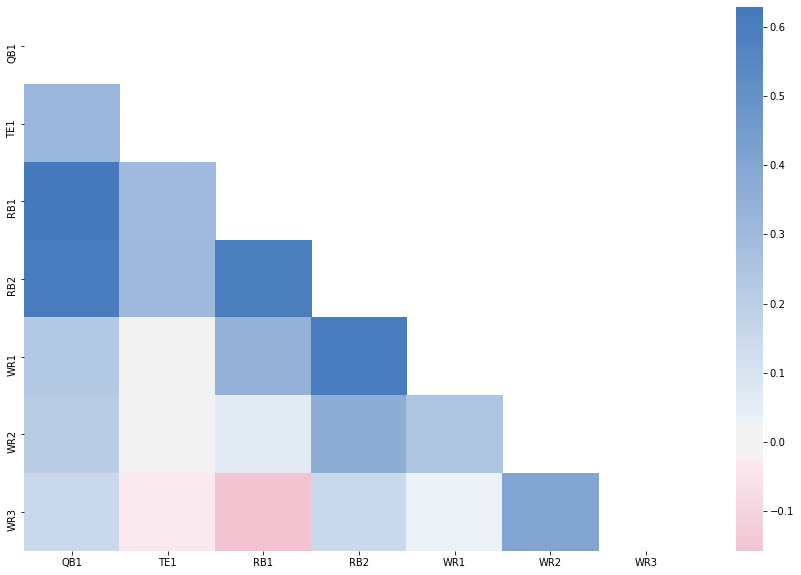

In [68]:
#Improve Heatmap
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

mask = np.zeros_like(corrMatrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

vizCorrMatrix = sns.heatmap(corrMatrix, mask=mask,cmap=cmap, center=0)

We first create a new canvas to “draw” the heatmap on. We set the dimensions again to 15×10.

Next, we create a “mask”. We do this using the built-in Numpy function zeros_like. It should look like a 7×7 numpy array with False for every value. Also, both pandas DataFrames and numpy arrays have a shape attribute which tells you the object’s dimensions. 

The function zeros_like takes an argument of a DataFrame, then a dtype (or data type). The function returns a numpy array with the same dimensions as our passed-in DataFrame, but with all the values set to zero. When we pass in a dtype as a boolean, though, it returns the array with all the values set to False.

With np.triu_indices_from(mask), we are getting the indices for the “upper triangle” of our mask. The function name triu_indices_from is shorthand for “triangle upper indices from”. We are essentially mapping True onto the upper triangle portion of our mask using mask[np.triu_indeces_from(mask)] = True, then passing that in to our seaborn plot to tell seaborn which corresponding/matching cells not to show in our heat map. 

Finally, we create our heatmap once again, this time passing in our mask, and our new, improved, and non-redundant heat map renders.